<a href="https://colab.research.google.com/github/elinteerie/Models/blob/main/Transfer_Learning_and_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Transfer Learning: Feature Extraction

In [1]:
import tensorflow as tf


In [2]:
import zipfile

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


#Unzip File
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-06-19 17:40:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.250.4.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  60.7MB/s    in 2.6s    

2022-06-19 17:40:34 (60.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import os

In [5]:
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}. ')

There are 2 directories and 0 images in 10_food_classes_10_percent. 
There are 10 directories and 0 images in 10_food_classes_10_percent/train. 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice. 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen. 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry. 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon. 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings. 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi. 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza. 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream. 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger. 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32



In [8]:
train_dir ='/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale =1/225.)

test_datagen= ImageDataGenerator(rescale =1/225.)

In [9]:
print('Training Images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size =IMAGE_SHAPE,
                                                          batch_size =BATCH_SIZE,
                                                          class_mode ='categorical',
                                                          )
print('Testing Images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                                          target_size =IMAGE_SHAPE,
                                                          batch_size =BATCH_SIZE,
                                                          class_mode ='categorical',
                                                          )

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


####Setting  up Callbacks 

In [10]:
#Create TensorBoard Callback

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir} ')
  return tensorboard_callback


###Creating Models using Tensorflow Hub

In [11]:
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [12]:
#Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras  import layers

In [13]:
#Create Model Function to create a model from url
def create_model(model_url, num_classes = 10):
  '''
  Takes a TensorFlow Hub Url and creates a Keras Sequential Model wwith it
  
  Args: 
    model_url(str): A TensorFlow hub feature extraction url.
    num_classes(int): Number of out neurons, number of target classes default 10
  
  Returns: uncompiled model as extractor 

  '''
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable = False,
                                           name ='feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE +(3,))
  model = tf.keras.Sequential([feature_extractor_layer,layers.Dense(num_classes, activation ='softmax', name ='output_layer')])

  return model

In [14]:
##Create Resnet Tensorflow model
resnet_model = create_model(resnet_url, num_classes= train_data_10_percent.num_classes)


In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
resnet_model.compile(loss='categorical_crossentropy', 
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy']
                     )

In [17]:
resnet_history = resnet_model.fit(train_data_10_percent, epochs = 5, 
                                steps_per_epoch =len(train_data_10_percent), validation_data= test_data,
                                callbacks =[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='resnetv250')]
                                )

Saving TensorBoard log files to: tensorflow_hub/resnetv250/20220619-174049 
Epoch 1/5
24/24 [==============================] - 31s 732ms/step - loss: 1.8674 - accuracy: 0.3880 - val_loss: 1.1723 - val_accuracy: 0.6428
Epoch 2/5
24/24 [==============================] - 16s 687ms/step - loss: 0.8871 - accuracy: 0.7427 - val_loss: 0.8383 - val_accuracy: 0.7372
Epoch 3/5
24/24 [==============================] - 19s 813ms/step - loss: 0.6059 - accuracy: 0.8320 - val_loss: 0.7496 - val_accuracy: 0.7548
Epoch 4/5
24/24 [==============================] - 16s 672ms/step - loss: 0.4654 - accuracy: 0.8813 - val_loss: 0.7112 - val_accuracy: 0.7624
Epoch 5/5
24/24 [==============================] - 16s 667ms/step - loss: 0.3702 - accuracy: 0.9173 - val_loss: 0.6927 - val_accuracy: 0.7704


####Plot Loss Curve For Transfer Learning

In [27]:
import matplotlib.pyplot as plt


#Plot validation training Curve
def plot_loss_curve(history):
  '''
  Return separate loss curves
  '''

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy= history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  ##Plot loss
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label = 'val_loss' )
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot Accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='Accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_loss' )
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend()

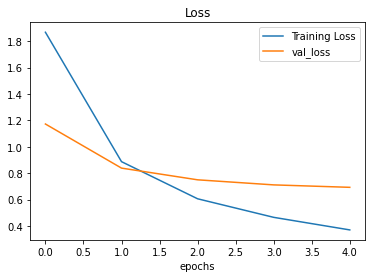

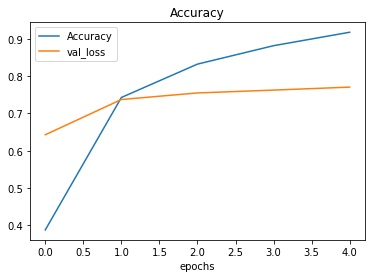

In [28]:
plot_loss_curve(resnet_history)

###Create EfficientNEt

In [29]:
netefficient_model = create_model(efficientnet_url, num_classes= train_data_10_percent.num_classes)


In [30]:
netefficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [31]:
netefficient_model.compile(loss='categorical_crossentropy', 
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy']
                     )

In [33]:
netefficient_history = netefficient_model.fit(train_data_10_percent, epochs = 5, 
                                steps_per_epoch =len(train_data_10_percent), validation_data= test_data,
                                callbacks =[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='efficient50')]
                                )

Saving TensorBoard log files to: tensorflow_hub/efficient50/20220619-175520 
Epoch 1/5
24/24 [==============================] - 17s 669ms/step - loss: 0.4705 - accuracy: 0.9040 - val_loss: 0.5597 - val_accuracy: 0.8524
Epoch 2/5
24/24 [==============================] - 15s 653ms/step - loss: 0.4134 - accuracy: 0.9160 - val_loss: 0.5272 - val_accuracy: 0.8604
Epoch 3/5
24/24 [==============================] - 15s 649ms/step - loss: 0.3688 - accuracy: 0.9280 - val_loss: 0.5081 - val_accuracy: 0.8636
Epoch 4/5
24/24 [==============================] - 15s 642ms/step - loss: 0.3309 - accuracy: 0.9453 - val_loss: 0.4905 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 15s 647ms/step - loss: 0.2982 - accuracy: 0.9520 - val_loss: 0.4759 - val_accuracy: 0.8652


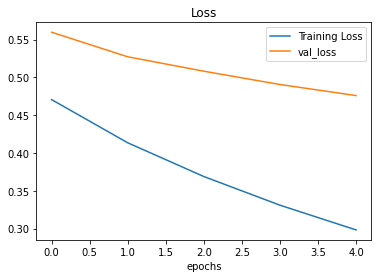

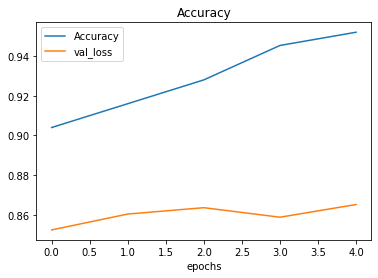

In [34]:
plot_loss_curve(netefficient_history)

###Using TensorBoard

In [37]:
#Upload tensorboard records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EfficientNetB0 vs. resnet_v2_50' \
  --description 'Conparing two different model' \
  --one_shot 


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=GvKc44WOUzRMmjLvff2MaZffpGISl5&prompt=consent&access_type=off

In [38]:
!tensorboard dev list

https://tensorboard.dev/experiment/Z5pCGiVpTPmgrIqzhapSdA/
	Name                 EfficientNetB0 vs. resnet_v2_50
	Description          Conparing two different model
	Id                   Z5pCGiVpTPmgrIqzhapSdA
	Created              2022-06-19 18:21:24 (6 minutes ago)
	Updated              2022-06-19 18:21:29 (6 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  8149928
Total: 1 experiment(s)
